In [17]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import re,string
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from gensim.models import KeyedVectors
from torch import Tensor
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
import math
import os
import warnings
warnings.filterwarnings('ignore')

In [18]:
df = pd.read_csv('/kaggle/input/nomvitranslate/nom-vi (1).csv')
df.shape

(62503, 2)

This dataset provides a set of 254,090 tuples containing an English source sentence, its Vietnamese human translation and we take 170000 set for training and evaluation

## Data Preprocessing

In [19]:
df.isna().sum()

nom    62
vi      2
dtype: int64

In [20]:
# Drop nan 
df = df.dropna()

In [21]:
def preprocessing(df): 
  df["vi"] = df["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))  
  df["vi"] = df["vi"].apply(lambda ele: ele.lower())
  df["vi"] = df["vi"].apply(lambda ele: ele.strip()) 
  df["vi"] = df["vi"].apply(lambda ele: re.sub("\s+", " ", ele))
    
  return df

df = preprocessing(df)
df.head()

,nom,vi
0,膿㺧,nọng heo
1,扽檜𤽗𡗉𩵜伵鮮,đòn củi ngươi nhiều cá tớ tươi
2,帝皆不問獨命勘,đế giai bất vấn độc mệnh khám
3,董鼎箕埃𩧍㗂持,đủng đỉnh kìa ai ruổi tiếng chày
4,香兔沉沁海若茹蛟豸俸蟾宫,hương thỏ chìm tăm hải nhược nhà giao giãi bón...


Tokenzing for english which is source language by tokenizer of basic english and vietnamese which is target language by Underthesea library

In [22]:
# Create source and target language tokenizer.
SRC_LANGUAGE = 'nom'
TGT_LANGUAGE = 'vi'

# Place-holders
token_transform = {}
vocab_transform = {}

# Tokenize for nom
def nom_tokenizer(sentence):
    return [*sentence]

# Tokenize for vietnames
def vi_tokenizer(sentence):
    return sentence.split()

token_transform[SRC_LANGUAGE] = get_tokenizer(nom_tokenizer)
token_transform[TGT_LANGUAGE] = get_tokenizer(vi_tokenizer)

# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:    
    for index,data_sample in data_iter:
        yield token_transform[language](data_sample[language])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = df.iterrows()
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [23]:
# def save_vocab(vocab,path):
#     import pickle
#     output = open(path, 'wb')
#     pickle.dump(vocab, output)
#     output.close()

In [24]:
# save_vocab(vocab_transform[SRC_LANGUAGE],'vocab_src.pkl')

## Model Defination

In [25]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Check whether running on gpu or cpu

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size) 
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)
   
    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [26]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Define the parameters of the model, instantiate the same and the loss function which is the cross-entropy loss and the optmizer used for training is Adam with β1 = 0.9, β2 = 0.98 and epsilon = 1e−9.

In [27]:
torch.manual_seed(0)
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 256
NHEAD = 4 # embed_dim must be divisible by num_heads
FFN_HID_DIM = 256
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROP_OUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM,DROP_OUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Define collate function that convert batch of raw strings into batch tensors that can be fed directly into model.

In [28]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor



     
# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Split data to train and test set

In [29]:
# Split data to tran test set
split_ratio = 0.9
split = round(df.shape[0]* split_ratio)
train = df.iloc[:split]
train_ds = list(zip(train['nom'],train['vi']))
valid = df.iloc[split:]
val_ds = list(zip(valid['nom'],valid['vi']))

Define training and evaluation loop that will be called for each epoch with Gradient accumulation which is a technique where you can train on bigger batch sizes than your machine would normally be able to fit into memory. This is done by accumulating gradients over several batches, and only stepping the optimizer after a certain number of batches have been performed.

In [30]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    val_los = 0
    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
     
    for src, tgt in tqdm(train_dataloader, leave=False):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)   
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        optimizer.zero_grad()
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step() 
        losses += loss.item()

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0

    #val_iter = valid.iterrows()
    val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

    return losses / len(val_dataloader)

Define an early stopping function to avoid the model from overfit

In [31]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:  
                self.early_stop = True

Training model

In [32]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)
NUM_EPOCHS = 50
history = {
        "loss": [], 
        "val_los": []
        }
best_valid_loss = float('inf')
valid_every = 5

for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if epoch % valid_every == 0:
        val_loss = evaluate(transformer)
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            save_model_path = os.path.join('./checkpoint/',f'train_loss{val_loss}.pt')
            path, _ = os.path.split(save_model_path)
            os.makedirs(path, exist_ok=True)
            torch.save(transformer.state_dict(), save_model_path)
        print((f"Val loss: {val_loss:.3f}"))
        history['val_los'].append(val_loss)
    history['loss'].append(train_loss)
    
    # Early Stopping
#     early_stopping(train_loss, val_loss)
#     if early_stopping.early_stop:
#         print("We are at epoch:", epoch)
#         break

Epoch: 1, Train loss: 6.607, Epoch time = 42.701s


Epoch: 2, Train loss: 4.980, Epoch time = 42.408s


Epoch: 3, Train loss: 2.852, Epoch time = 42.427s


Epoch: 4, Train loss: 1.796, Epoch time = 42.523s


Epoch: 5, Train loss: 1.339, Epoch time = 42.390s
Val loss: 1.197


Epoch: 6, Train loss: 1.099, Epoch time = 42.628s


Epoch: 7, Train loss: 0.946, Epoch time = 42.675s


Epoch: 8, Train loss: 0.838, Epoch time = 42.199s


Epoch: 9, Train loss: 0.754, Epoch time = 42.306s


Epoch: 10, Train loss: 0.685, Epoch time = 42.532s
Val loss: 0.836


Epoch: 11, Train loss: 0.627, Epoch time = 42.476s


Epoch: 12, Train loss: 0.576, Epoch time = 42.298s


Epoch: 13, Train loss: 0.534, Epoch time = 42.590s


Epoch: 14, Train loss: 0.495, Epoch time = 42.355s


Epoch: 15, Train loss: 0.462, Epoch time = 42.304s
Val loss: 0.719


Epoch: 16, Train loss: 0.430, Epoch time = 42.455s


Epoch: 17, Train loss: 0.404, Epoch time = 42.574s


Epoch: 18, Train loss: 0.379, Epoch time = 42.488s


Epoch: 19, Train loss: 0.355, Epoch time = 42.416s


Epoch: 20, Train loss: 0.334, Epoch time = 42.404s
Val loss: 0.659


Epoch: 21, Train loss: 0.313, Epoch time = 42.499s


Epoch: 22, Train loss: 0.296, Epoch time = 42.360s


Epoch: 23, Train loss: 0.279, Epoch time = 42.406s


Epoch: 24, Train loss: 0.264, Epoch time = 42.646s


Epoch: 25, Train loss: 0.249, Epoch time = 42.404s
Val loss: 0.620


Epoch: 26, Train loss: 0.236, Epoch time = 42.329s


Epoch: 27, Train loss: 0.224, Epoch time = 42.475s


Epoch: 28, Train loss: 0.212, Epoch time = 42.619s


Epoch: 29, Train loss: 0.202, Epoch time = 42.254s


Epoch: 30, Train loss: 0.191, Epoch time = 42.566s
Val loss: 0.622


Epoch: 31, Train loss: 0.183, Epoch time = 42.365s


Epoch: 32, Train loss: 0.172, Epoch time = 42.779s


Epoch: 33, Train loss: 0.164, Epoch time = 42.399s


Epoch: 34, Train loss: 0.156, Epoch time = 42.512s


Epoch: 35, Train loss: 0.149, Epoch time = 42.511s
Val loss: 0.637


Epoch: 36, Train loss: 0.141, Epoch time = 42.309s


Epoch: 37, Train loss: 0.135, Epoch time = 42.394s


Epoch: 38, Train loss: 0.127, Epoch time = 42.622s


Epoch: 39, Train loss: 0.122, Epoch time = 42.648s


Epoch: 40, Train loss: 0.116, Epoch time = 42.312s
Val loss: 0.647


Epoch: 41, Train loss: 0.111, Epoch time = 43.054s


Epoch: 42, Train loss: 0.106, Epoch time = 42.338s


Epoch: 43, Train loss: 0.101, Epoch time = 42.357s


Epoch: 44, Train loss: 0.096, Epoch time = 42.533s


Epoch: 45, Train loss: 0.092, Epoch time = 42.622s
Val loss: 0.650


Epoch: 46, Train loss: 0.088, Epoch time = 42.549s


Epoch: 47, Train loss: 0.085, Epoch time = 42.759s


Epoch: 48, Train loss: 0.081, Epoch time = 42.275s


Epoch: 49, Train loss: 0.078, Epoch time = 42.518s


Epoch: 50, Train loss: 0.075, Epoch time = 42.505s
Val loss: 0.633


Traning and Validate plotting

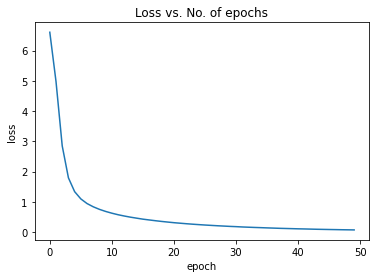

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history['loss'], label = "loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

**Inference**

In [34]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

In [38]:
translate(transformer, '身㛪辰𤽸分㛪𧷺')

' thân em thì trắng phận em tròn '

In [36]:
# Saving model
torch.save(transformer.state_dict(), "transformer_pretrained.pt")

Testing model by randomly take 10 samples from the rest of the dataset

In [37]:
from random import randint
rand = [randint(0,6169) for i in range(10)]
test_set = [
        [valid.iloc[i]['nom'] for i in rand],
        [valid.iloc[i]['vi'] for i in rand]]
    
for i in range(len(test_set[0])):
    print('Input:', test_set[0][i])
    print('Actual Translation:', test_set[1][i])
    print('Predicted Translation:', translate(transformer, test_set[0][i]))
    print("\n")

Input: 鮮肉舌𫪹哉
Actual Translation: tiên nhục thịt sống còn tươi
Predicted Translation:  tiên nhục thịt sống tai 


Input: 帝出據州城即龍編也
Actual Translation: đế xuất cứ châu thành tức long biên dã
Predicted Translation:  đế xuất cứ châu thành tức long biên dã 


Input: 源恩箕空蕯麻潙
Actual Translation: nguồn ơn kia không tát mà vơi
Predicted Translation:  nguồn ân kia không tát mà vơi 


Input: 掬制春泣每頽
Actual Translation: cuốc chơi xuân khắp mọi đồi
Predicted Translation:  cuốc chơi xuân khắp mọi đồi 


Input: 大牙𫆢丐於歌边含
Actual Translation: đại nha răng cái ở ca bên hàm
Predicted Translation:  đại nha răng cái ở ca bên hàm 


Input: 娘浪隻栢㳥濤
Actual Translation: nàng rằng chiếc bách sóng đào
Predicted Translation:  nàng rằng chiếc bách sóng đào 


Input: 三月令各衙門吏鄕試中式除正官
Actual Translation: tam nguyệt lệnh các nha môn lại hương thí trúng thức trừ chính quan
Predicted Translation:  tam nguyệt lệnh các nha môn lại hương thí trúng thức trừ chính quan 


Input: 爫𠊚𢪀善等冲𡎝𠊚
Actual Translation: làm người nghĩ thẹn đ

**References**

https://pytorch.org/tutorials/beginner/translation_transformer.html